This solution accelerator notebook is available at https://github.com/databricks-industry-solutions/causal-incentive.

In [1]:
%run ../util/notebook-config

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html


#Discovering the network of influences among the Features

In order to isolate the influence we plan to estimate,  we need first to understand the relations among the available features.  We will use [PC algorithm](https://www.youtube.com/watch?v=o2A61bJ0UCw) implemented in the [PyWhy](https://www.pywhy.org/) package called [causal-learn](https://github.com/py-why/causal-learn), to discover the basic skeleton of the network. Before generating the skeleton, it is possible to set some requirements on the graph. For example, we discussed in the previous notebook that ```Size``` affects ```IT Spend``` and ```Employee Count``` influences ```PC Count```. We will add these causal connections when we generate the graph.

In [3]:
import pandas as pd
import numpy as np

file_url = "https://msalicedatapublic.z5.web.core.windows.net/datasets/ROI/multi_attribution_sample.csv"
input_df = pd.read_csv(file_url)

Depth=5, working on node 10: 100%|██████████| 11/11 [00:00<00:00, 1571.22it/s]


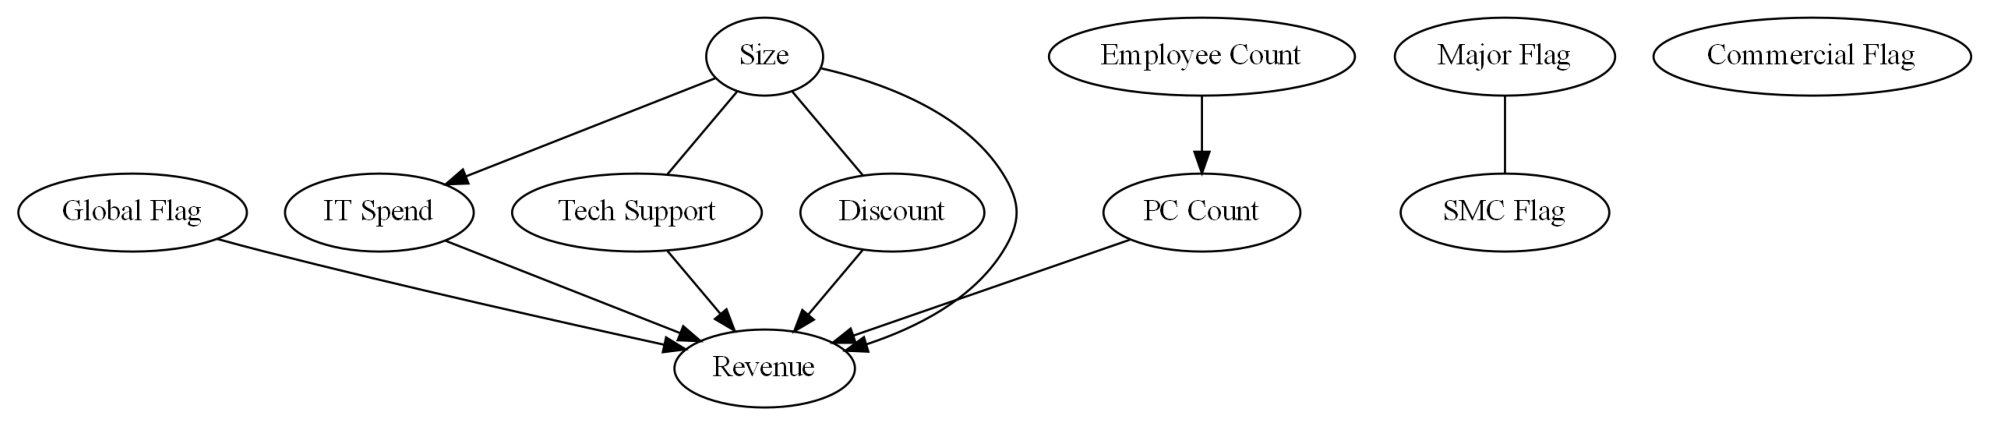

In [4]:
%matplotlib inline
import causallearn
from causallearn.search.ConstraintBased.PC import pc

required_edges = [
    {"from": "Size", "to": "IT Spend"},
    {"from": "Employee Count", "to": "PC Count"},
]

# Get the background_knowledge parameter from the required edges defined above. 
background_knowledge = add_background_knowledge(
  edges = required_edges
)

# Parameters
parameters = {"node_names": input_df.columns, 
              "background_knowledge": background_knowledge, 
              "alpha": 0.01, 
              "indep_test": "fisherz"}

cg = pc(data=np.vstack(input_df.to_numpy()), **parameters)

# Visualization using pydot
cg.draw_pydot_graph()

The bare bones skeleton discovered offers some interesting insights:

- ```Discount``` seems to have a direct impact in ```Revenue```.
- ```Tech Support``` appears to have a direct impact in ```Revenue``` and a mediated one through ```New Product Adoption```.
- The ```New Engagement Strategy``` seems not to influence ```Revenue```.
- Both ```Revenue``` and ```New Engagement Strategy``` influence ```Planning Summit```. This representas a [collider pattern](https://en.wikipedia.org/wiki/Collider_(statistics)) which could result in creating a fictitious relation between ```New Engagement Strategy``` and ```Revenue``` if ```Planning Summit``` is included as a feature during the influence estimation!! (this pattern is also known as [selection bias](https://catalogofbias.org/biases/collider-bias/))

#Adding Domain Knowledge Assumptions to the Network

The skeleton lacks directions in some of the relations.  Some of the missing directions are obvious:

- ```IT Spend``` -> ```Tech Support```
- ```Tech Support``` -> ```New Product Adoption```
- ```Major Flag``` -> ```New Engagment Strategy```

We will add these directions to the network:

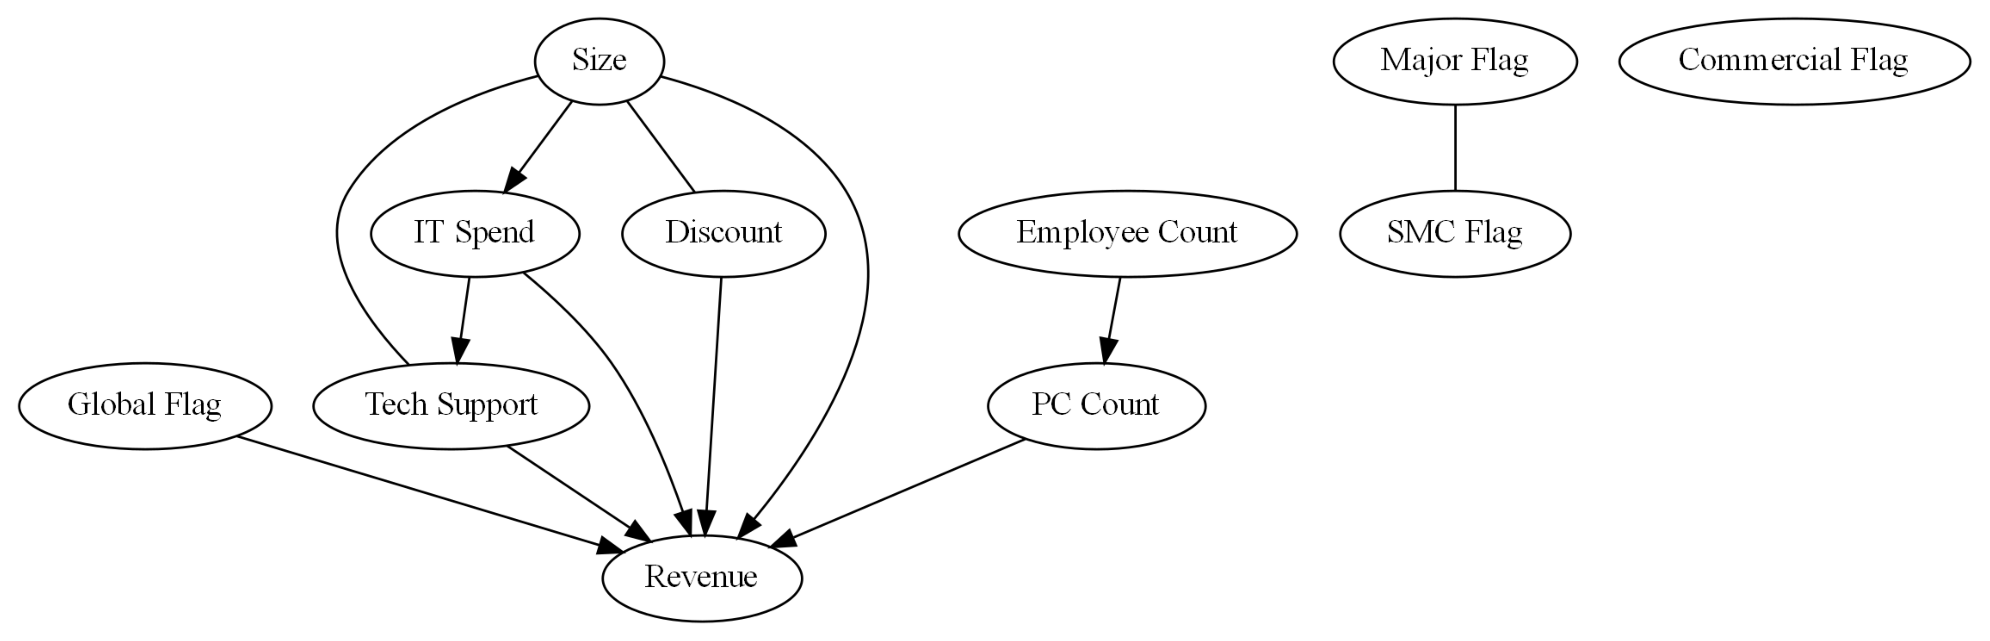

In [5]:
# Adding missing directions
added_directions = [
    {"from": "IT Spend", "to": "Tech Support"}
    # {"from": "Tech Support", "to": "New Product Adoption"},
    # {"from": "Major Flag", "to": "New Engagement Strategy"},
]

add_directions(
    causal_graph=cg,
    directions=added_directions,
)

cg.draw_pydot_graph()

Some of the discovered directions are clearly wrong:

- ```Revenue``` should not convert a company from the commercial sector to the public sector
- Providing the ```New Engagement Strategy``` incentive to a company will not converted it from the commerical sector to the public sector

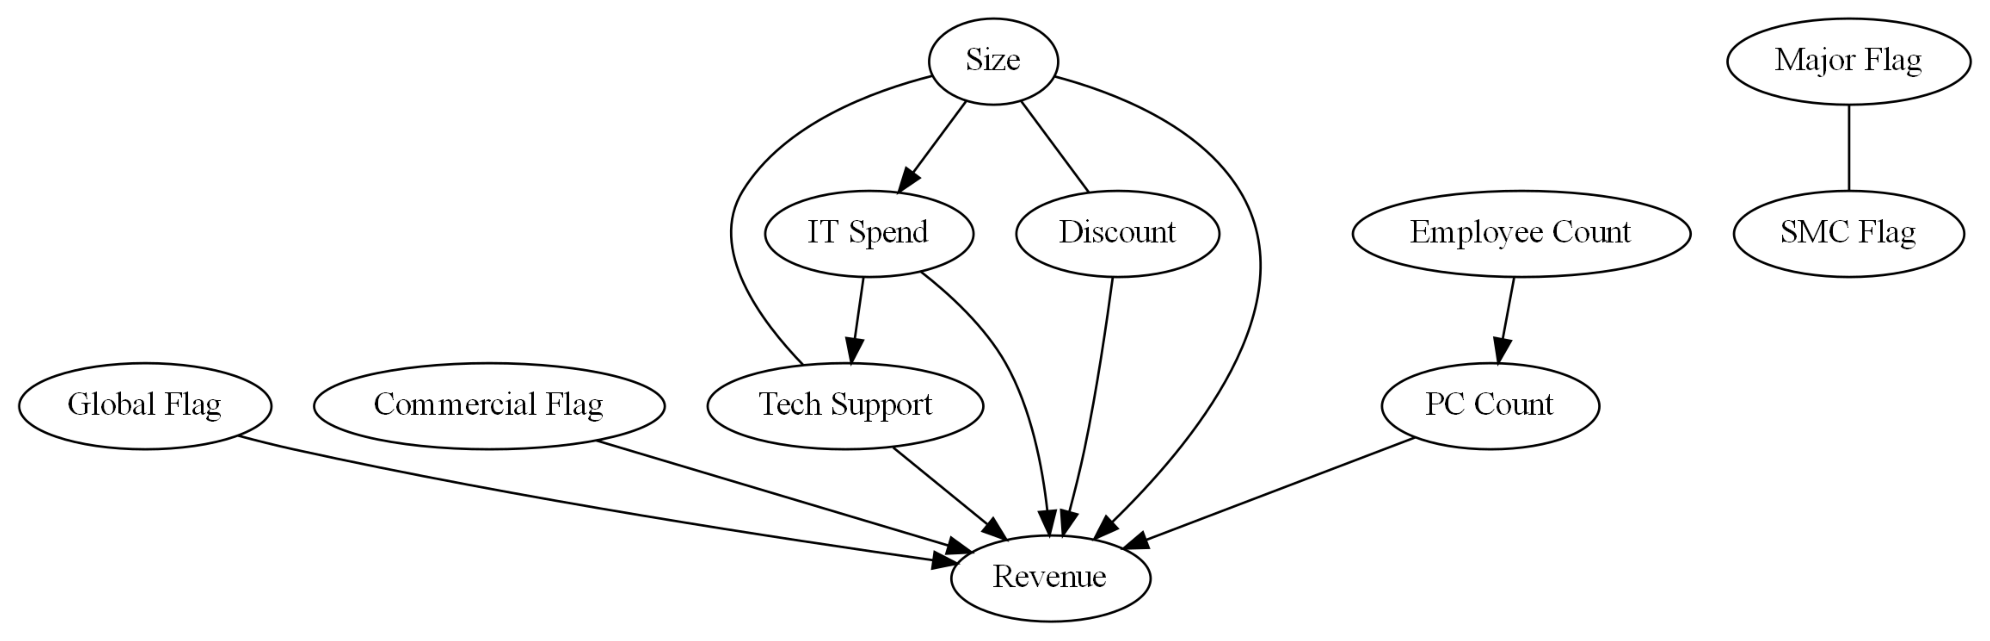

In [6]:
# Correcting directions
inverted_directions = [
    {"from": "Revenue", "to": "Commercial Flag"}
    # {"from": "New Engagement Strategy", "to": "Commercial Flag"},
]
invert_directions(
    causal_graph=cg,
    directions=inverted_directions,
)

cg.draw_pydot_graph()

Even though some relations were not automatically discovered, The business experts of the software company are pretty convinced ```Global Flag``` and ```Major Flag``` have an influence in ```Revenue```.  We will add these assumptions to the network

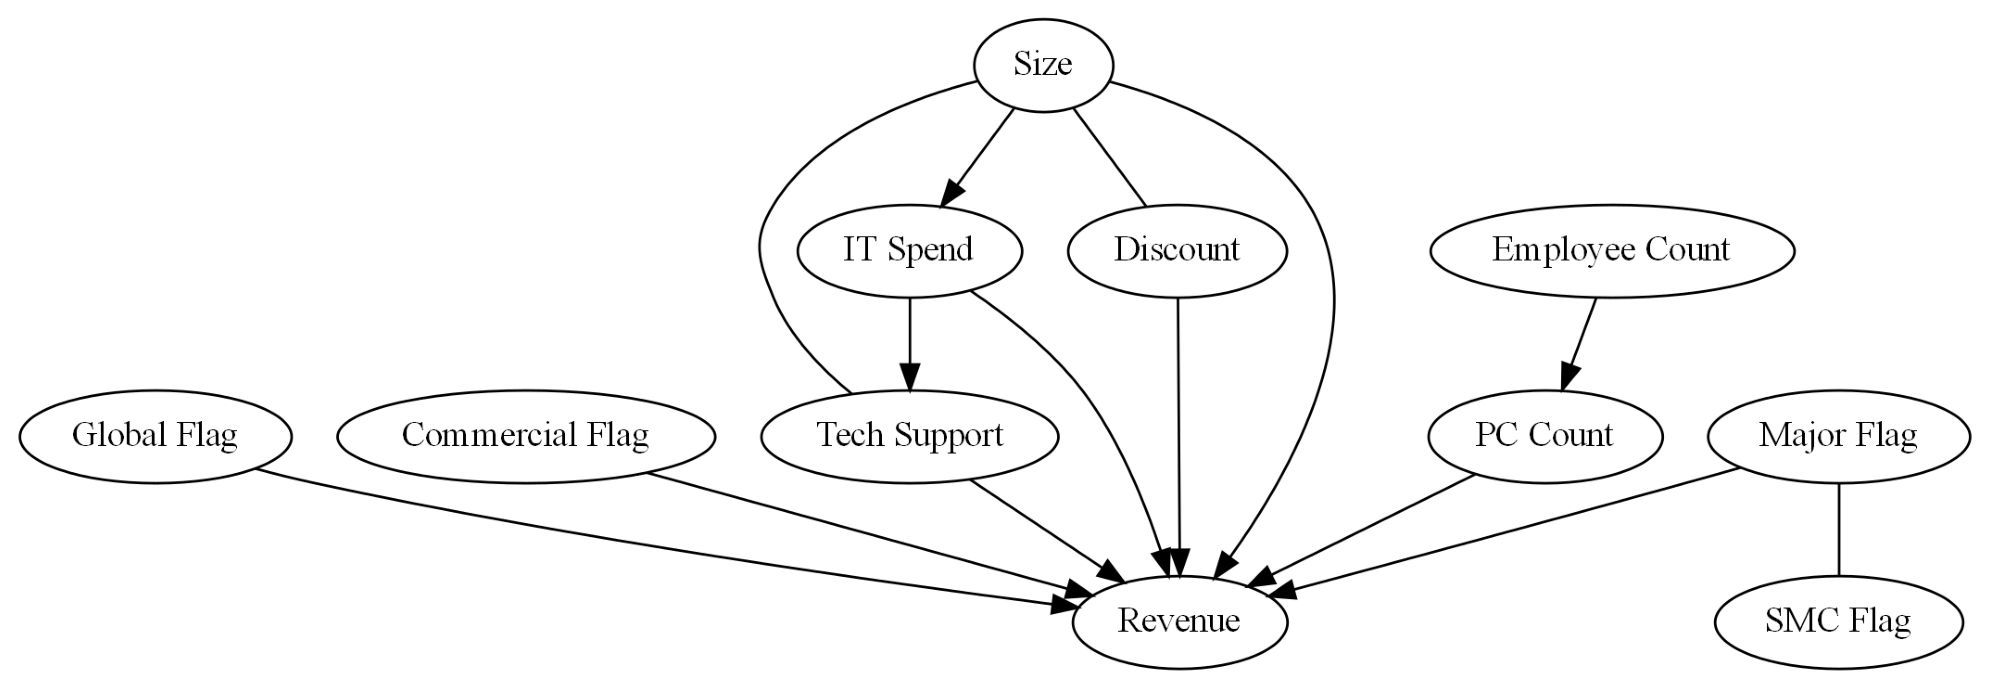

In [7]:
# Adding missing relations based on domain knowledge
added_missing_directed_relations = [
    {"from": "Global Flag", "to": "Revenue"},
    {"from": "Major Flag", "to": "Revenue"},
]

add_directions(
    causal_graph=cg,
    directions=added_missing_directed_relations,
)

cg.draw_pydot_graph()

Finally, even thought there was no incentive assignation policy, we believe the basic characteristics of the company had an influence in the assignation.  We will add a directed relation from each of these characteristics to each of the promotional offers

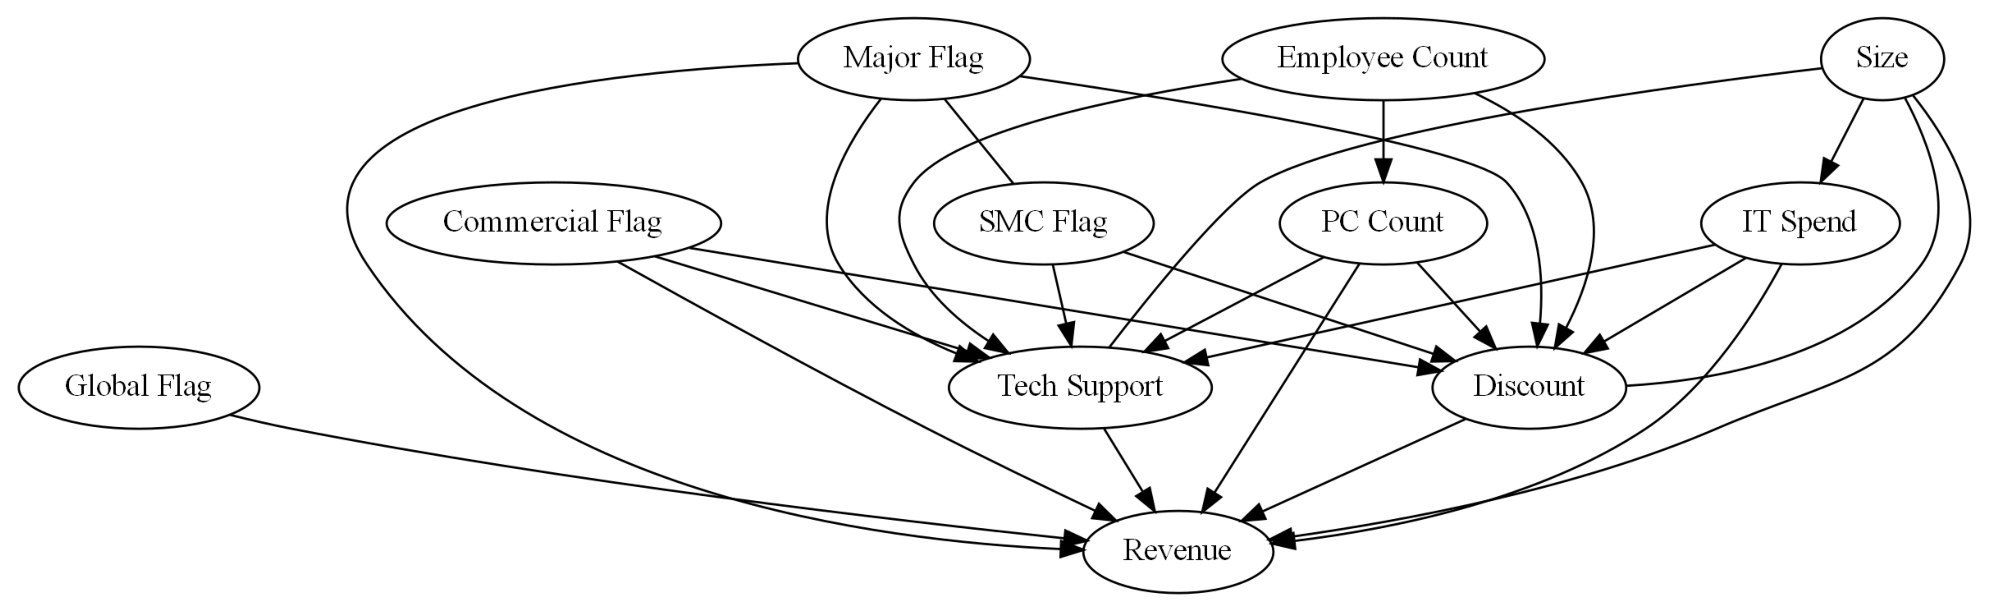

In [8]:
# Add effect from all basic characteristics to incentives
account_basic_characteristics = [
    "Major Flag",
    "SMC Flag",
    "Commercial Flag",
    "IT Spend",
    "Employee Count",
    "PC Count",
]

add_relations_influencing_incentives(
    causal_graph=cg,
    incentives=["Discount", "Tech Support"],
    account_basic_characteristics=account_basic_characteristics,
)

cg.draw_pydot_graph()

The network defined above,  also known as the Causal Graph, will guide the <b>identification</b> and <b>estimation</b> phases.  We will proceed to store it as an artifact in an MLFlow experiment run to then use it in the next step (the ```02_identification_estimation``` notebook).  

Please notice we are also storing in the [MLfLow](https://databricks.atlassian.net/wiki/spaces/UN/pages/2893873880/Brickstore) the algorithm used for the discovery, the parameters applied to the algorithm,  and all the alterations made to the discovered graph skeleton.

In [21]:
import pickle

with open('multidata_graph.pkl', 'wb') as f:
    pickle.dump(cg, f)

In [12]:
import mlflow

mlflow.login()

2024/05/23 01:42:30 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [15]:
mlflow.set_tracking_uri("databricks")

In [16]:
with mlflow.start_run(run_name="causal_discovery") as run:
    mlflow.log_params(
        {
            **{
                "algorithm": "PC",
                "library": f"causal-learn=={get_version('causal-learn')}",
            },
            **parameters,
            **{
                "added_directions": str(added_directions),
                "inverted_directions": str(inverted_directions),
                "added_missing_directed_relations": str(
                    added_missing_directed_relations
                ),
                "account_basic_characteristics": str(account_basic_characteristics),
            },
        }
    )

    # Serialize the graph to a file and log it to MLflow for reference.
    graph = to_pydot(cg.G, labels=input_df.columns)
    with open("/databricks/driver/graph.txt", "w") as f:
        f.write(graph)

    mlflow.log_artifact("/databricks/driver/graph.txt", artifact_path="graph")

MlflowException: API request to endpoint /api/2.0/mlflow/runs/create failed with error code 404 != 200. Response body: ''

© 2023 Databricks, Inc. All rights reserved. The source in this notebook is provided subject to the Databricks License. All included or referenced third party libraries are subject to the licenses set forth below.

| library                                | description             | license    | source                                              |
|----------------------------------------|-------------------------|------------|-----------------------------------------------------|
| dowhy   | Python library for causal inference that supports explicit modeling and testing of causal assumptions | MIT   | https://pypi.org/project/dowhy/          
| econml   |  contains several methods for calculating Conditional Average Treatment Effects | MIT    | https://pypi.org/project/econml/  
| causal-learn   | python package for causal discovery  | MIT    | https://pypi.org/project/causal-learn/